1.  This notebook include code and experimentation for 'choice recency module' with sarsa, for explanation see slides or report.

2.  Updated normal softmax action select such that it incorporated the choice and coefficient b.

3.  the algo uses the working memory module to learn the replenishment rates which are used to calculate b.

In [14]:
!pip3 install -e gym-env

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/kabhay/Documents/courses/RL_project/Foraging_in_replenishing_patches/gym-env
  Attempting uninstall: gym-env
    Found existing installation: gym-env 0.0.1
    Uninstalling gym-env-0.0.1:
      Successfully uninstalled gym-env-0.0.1
  Running setup.py develop for gym-env
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [15]:
import gym
from gym import error, spaces, utils
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib

In [16]:
from blocks import EnvClass

In [17]:
def playEnv(env,policy):
    
    env.reset()
    
    s = env.present_state
    
    done = False

    a = int(policy[s][0])

    cur_reward = 0

    while not done:

        out = env.step(a)

        (s_prime,t),r,done,_ = out
        
        cur_reward += r
        a = int(policy[int(s_prime)][int(r)])
        
    return cur_reward

In [18]:
def decayEpsilon(eps,noEpisodes,decayUntil,min_eps=0.01,decayType='linear'):
    
    epsilons = np.empty(noEpisodes)
    
    epsilons.fill(min_eps)
    
    if decayType == 'linear':
        
        rate = (eps - min_eps) / decayUntil
        
        for i in range(decayUntil+1):
            epsilons[i] = eps - i*rate
    
    else :
        
        rate = (eps/min_eps)** (1/decayUntil)
        
        for i in range(decayUntil+1):
            epsilons[i] = eps * (rate**i)

    
    return epsilons

In [19]:
def decayAlpha(alpha, noEpisodes,maxSteps,final_alpha = 0.01,decayType='linear'):
    
    alphas = [float(final_alpha)] * noEpisodes
    
    if decayType == 'linear':
        
        rate = (alpha - final_alpha) / maxSteps
        
        for i in range(maxSteps+1):
            alphas[i] = alpha - i*rate
    
    else :
        
        rate = (final_alpha/alpha)** (1/maxSteps)
        
        for i in range(maxSteps+1):
            alphas[i] = alpha * (rate**i)
    
    return alphas

In [20]:
def actionSelect(s,r,Q,eps):
    
    q = Q[s][r]
    
    if np.random.rand() > eps:
        a = np.random.choice(np.where(q == q.max())[0])
    else :
        a = np.random.randint(0,len(q))
    
    return a

In [21]:
def GreedyPolicy(Q):
    
    pi = np.zeros((Q.shape[0],Q.shape[1]))
    
    for s in range(Q.shape[0]):
        
        for r in range(Q.shape[1]):
            
            q = Q[s][r]

            #simple_argmax

            a = np.argmax(q)

            #a = np.random.choice(np.where(q == q.max())[0])

            pi[s][r] = int(a)
        
    return pi

In [22]:
from tqdm import tqdm

### CHOICE RECENCY MODULE

In [146]:
def playCustomEnv(env,Q,b):
    
    env.reset()
    
    
    def decayChoice(choice,s,r,chosen_action):
        choice[s][r] = choice[s][r] * 0.7
        choice[s][r][chosen_action] = 1 
        
    s = env.present_state
    
    done = False

    choice  = 10* np.ones((9,201,8))
    
    curr_state = s
    
    a = np.argmax((Q[curr_state][0] + b[curr_state] * choice[curr_state][0]))

    cur_reward = 0

    while not done:

        out = env.step(a)
        
        (s_prime,t),r,done,_ = out
        
        decayChoice(choice,s,r,a)
        
        cur_reward += r
        
        a = np.argmax((Q[s_prime][r] + b[s_prime] * choice[s_prime][r]))
        
        s = s_prime
        
    return cur_reward
    

In [35]:

def softmax_actionSelect(curr_state,curr_r,Q,choice,tau,b,e):
    
    val = (Q[curr_state][curr_r] + b[curr_state] * choice[curr_state][curr_r])/tau
    
    probs = np.exp(val)/np.sum(np.exp(val))
    
    a = np.random.choice(8,p=probs)
    
    return a

In [312]:

def Softmax_SARSA(env,taus,gamma,alpha,noEpisodes,epsilons = [0]) :
    
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    
    Q = np.zeros((n_states,201,n_actions))
    
    if epsilons[0] == 0:
        epsilons = decayEpsilon(1,noEpisodes,noEpisodes,min_eps = 0.1, decayType = 'linear')
        
    alphas = decayAlpha(alpha,noEpisodes,int(3*noEpisodes/4) ,final_alpha = 0.02 ,decayType = 'linear')
    
    
    
    rewards = np.zeros((noEpisodes)) 
    greedy_rewards = np.zeros((noEpisodes))

    
    replenishing_rate = np.zeros(8)
    
    def decayChoice(choice,s,r,chosen_action):
        choice[s][r] = choice[s][r] * 0.7
        choice[s][r][chosen_action] = 1 
        
    def estimate_b(replenishing_rate,b):
        
        for i in range(8):
            
            if replenishing_rate[i] > 0:  
                b[i] = replenishing_rate[i] / np.min(replenishing_rate[replenishing_rate> 0]) 
            
            else :
                b[i] = -1
            
        
    for e in tqdm(range(noEpisodes)):
        
        cur_alpha = alphas[e]
        env.reset()
        s = env.present_state
        done = False
        
        tau = taus[e]
        
        choice = 10*np.ones((n_states,201,n_actions))
        b = np.zeros(9)
        
        a = softmax_actionSelect(s,0,Q,choice,tau,b,e)
    
        eps_reward = 0

        r = 0
        
        time = 0
        flag = 0
        
        last_returned_reward = np.zeros(8)
        last_visit_time = np.zeros(8)
        
        while not done:

            out = env.step(a)
            
            
            
            (s_prime,t),r_new,done,_ = out
            
            s_new = [s_prime,t]
            curr_state = s
            
            time = 300-s_new[1]

            if(flag):
                if(s_new[0]== curr_state):
                    if(r_new > last_returned_reward[s_new[0]] and last_visit_time[curr_state]!=0):
                        temp = 0.6*replenishing_rate[s_new[0]] + 0.4*(max(r_new-last_returned_reward[s_new[0]], 0)/(time - last_visit_time[s_new[0]]))
                        replenishing_rate[s_new[0]] = temp
                    
                    last_visit_time[curr_state] = time

                flag = 0

            if(time - last_visit_time[s_new[0]]>1):
                flag = 1

            if(flag ==0):    
                last_visit_time[s_new[0]] = time
                last_returned_reward[s_new[0]] = r_new
            
            decayChoice(choice,s,r,a)
            eps_reward += r_new
            
            estimate_b(replenishing_rate,b)
            
            a_prime = softmax_actionSelect(s_prime,int(r_new),Q,choice,tau,b,e)
            
            td_target = r_new
            
            if not done :
                td_target += gamma * Q[s_prime][int(r_new)][a_prime]
                
            td_error = td_target - Q[s][int(r)][a]
                
            Q[s][int(r)][a] = Q[s][int(r)][a] + cur_alpha * td_error
            
            s = s_prime
            
            a = a_prime
            
            r = r_new
            
#         print(replenishing_rate)
            
        rewards[e] = eps_reward
        greedy_rewards[e] = playCustomEnv(env,Q,b)
    
    pi = GreedyPolicy(Q)
    
    return Q,pi,rewards,greedy_rewards,b,replenishing_rate
    

## Experimentation

In [313]:
envs = EnvClass()

### Block 1

In [190]:
env_b1 = envs.getBlock(1)
num_seeds = 3

n_states = 9
n_actions = 8

alpha = 0.5
gamma = 0.4
noEpisodes = 10000
tau_i = 1000
tau_f = 10
lin_r = (tau_f - tau_i) / (noEpisodes-1)
exp_r = (tau_f/tau_i)**(1/(noEpisodes-1))
taus = [ tau_i*(exp_r**i) for i in range(noEpisodes)]
# taus = [ tau_i+i*lin_r  for i in range(noEpisodes)]


Q_ = np.zeros((num_seeds, n_states,201,n_actions)) 
sof_rewards_ = np.zeros((num_seeds,noEpisodes))
sof_greedy_ = np.zeros((num_seeds,noEpisodes))
b_ = np.zeros((num_seeds,9))
rep_rates = np.zeros((num_seeds,8))

In [191]:
for i in range(num_seeds):    
    np.random.seed(10*(i+1))
    epsilons = np.ones((noEpisodes))
    Q_[i],pi1,sof_rewards_[i],sof_greedy_[i],b_[i],rep_rates[i] = Softmax_SARSA(env_b1,taus,gamma,alpha,noEpisodes,epsilons)

100%|██████████| 10000/10000 [03:14<00:00, 51.47it/s]


In [192]:
sof_avg_rewards = np.mean(sof_rewards_,axis = 0)

In [193]:
sof_avg_greedy = np.mean(sof_greedy_,axis = 0)

In [194]:
Q_avg = np.mean(Q_,axis = 0)

In [195]:
sof_pi_ = GreedyPolicy(Q_avg)

In [196]:
playEnv(env_b1,sof_pi_)

19116

In [201]:
rep_rates,b_

(array([[0.        , 2.08458016, 1.79121401, 0.        , 1.84442298,
         0.        , 2.23053903, 0.        ],
        [0.        , 1.86220285, 1.743757  , 0.        , 1.41912924,
         0.        , 1.87670128, 0.        ],
        [0.        , 2.39137876, 2.24000997, 0.        , 2.40341782,
         0.        , 2.34882097, 0.        ]]),
 array([[-1.,  1.,  1., -1.,  1., -1.,  1., -1.,  0.],
        [-1.,  1.,  1., -1.,  1., -1.,  1., -1.,  0.],
        [-1.,  1.,  1., -1.,  1., -1.,  1., -1.,  0.]]))

In [206]:
# b = [-1,  1,  1, -1,  1, -1,  1, -1,  0.]
playCustomEnv(env_b1,Q_avg,b_[0])

21743

In [205]:
for i in range(num_seeds):
    print(playCustomEnv(env_b1,Q_[i],b_[i]))

18472
19268
19678


Text(0.5, 1.0, 'SARSA reward for block 1')

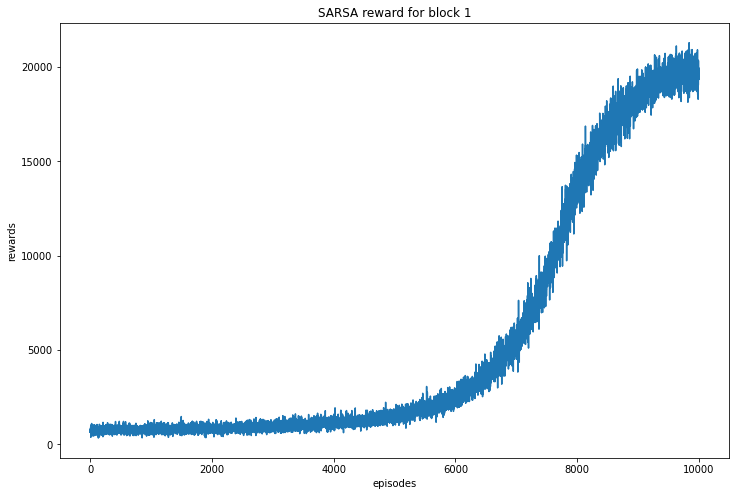

In [202]:
plt.figure(figsize=(12,8))
plt.plot(sof_avg_rewards)
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.title("SARSA reward for block 1")

Text(0.5, 1.0, 'SARSA reward for block 1')

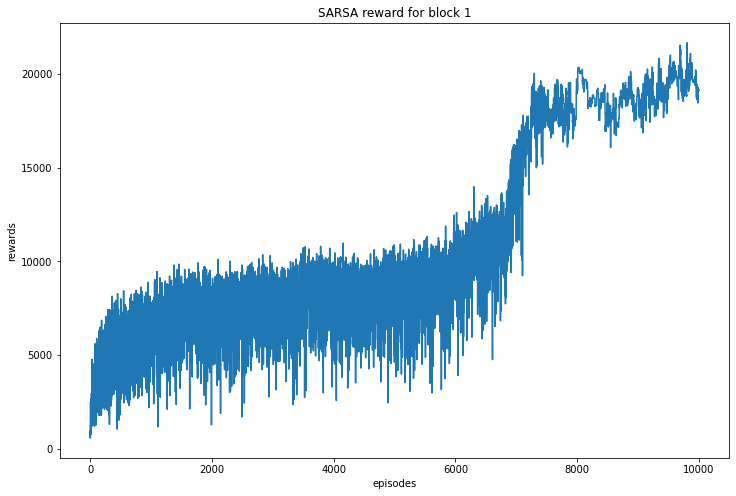

In [203]:
plt.figure(figsize=(12,8))
plt.plot(sof_avg_greedy)
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.title("SARSA reward for block 1")

In [2]:
# saving files

In [207]:
np.savez('./policies/sarsa/sarsa_learning_choice_04_B1_sof_reward.npz', sof_rewards_)
np.savez('./policies/sarsa/sarsa_learning_choice_04_B1_sof_greedy.npz', sof_greedy_)
np.savez('./policies/sarsa/sarsa_learning_choice_04_B1_Q.npz', Q_)
np.savez('./policies/sarsa/sarsa_learning_choice_04_B1_rep_rates.npz', rep_rates)

### Block2

In [387]:
env_b2 = envs.getBlock(2)
num_seeds = 3

n_states = 9
n_actions = 8

alpha = 0.5
gamma = 0.3
noEpisodes = 1000
tau_i = 1000
tau_f = 10
lin_r = (tau_f - tau_i) / (noEpisodes-1)
exp_r = (tau_f/tau_i)**(1/(noEpisodes-1))
taus = [ tau_i*(exp_r**i) for i in range(noEpisodes)]
# taus = [ tau_i+i*lin_r  for i in range(noEpisodes)]


Q_ = np.zeros((num_seeds, n_states,201,n_actions)) 
sof_rewards_ = np.zeros((num_seeds,noEpisodes))
sof_greedy_ = np.zeros((num_seeds,noEpisodes))
b_ = np.zeros((num_seeds,9))
rep_rates = np.zeros((num_seeds,8))

In [388]:
for i in range(num_seeds):    
    np.random.seed(20*i+1)
    epsilons = np.ones((noEpisodes))
    Q_[i],pi1,sof_rewards_[i],sof_greedy_[i],b_[i],rep_rates[i] = Softmax_SARSA(env_b2,taus,gamma,alpha,noEpisodes,epsilons)

100%|██████████| 1000/1000 [00:21<00:00, 46.98it/s]


In [389]:
rep_rates,b_

(array([[0.        , 0.        , 1.21852124, 0.64944112, 0.        ,
         0.63606371, 0.        , 1.72876186],
        [0.        , 0.        , 2.85968936, 0.90120309, 0.        ,
         0.63598733, 0.        , 3.12767891],
        [0.        , 0.        , 2.10430004, 0.64801208, 0.        ,
         0.45424211, 0.        , 2.52994564]]),
 array([[-1.        , -1.        ,  1.91572199,  1.02103155, -1.        ,
          1.        , -1.        ,  2.71790676,  0.        ],
        [-1.        , -1.        ,  4.49645646,  1.41701421, -1.        ,
          1.        , -1.        ,  4.91783207,  0.        ],
        [-1.        , -1.        ,  4.63255166,  1.42657862, -1.        ,
          1.        , -1.        ,  5.56959733,  0.        ]]))

In [390]:
sof_avg_rewards = np.mean(sof_rewards_,axis = 0)

In [391]:
sof_avg_greedy = np.mean(sof_greedy_,axis = 0)

In [392]:
Q_avg = np.mean(Q_,axis = 0)

In [393]:
sof_pi_ = GreedyPolicy(Q_avg)

In [394]:
playEnv(env_b2,sof_pi_)

17020

In [399]:
# b = [-1,  1,  1, -1,  1, -1,  1, -1,  0.]
playCustomEnv(env_b2,Q_avg,np.mean(b_,axis=0))

19456

In [397]:
playCustomEnv(env_b2,Q_avg,b_[0])

19801

In [398]:
for i in range(num_seeds):
    print(playCustomEnv(env_b2,Q_[i],b_[i]))

19183
20003
18536


In [400]:
sof_greedy_[:,-1]

array([19183., 20003., 18536.])

In [310]:
replenishing_rate = rep_rates[0]

In [311]:
replenishing_rate[replenishing_rate> 0]

array([3.74094002, 1.0984315 , 0.93705727, 4.45741603])

In [401]:
np.savez('./policies/sarsa/sarsa_learning_choice_04_B2_sof_reward.npz', sof_rewards_)
np.savez('./policies/sarsa/sarsa_learning_choice_04_B2_sof_greedy.npz', sof_greedy_)
np.savez('./policies/sarsa/sarsa_learning_choice_04_B2_Q.npz', Q_)
np.savez('./policies/sarsa/sarsa_learning_choice_04_B2_rep_rates.npz', rep_rates)

### Block3

In [402]:
env_b3 = envs.getBlock(3)
num_seeds = 3

n_states = 9
n_actions = 8

alpha = 0.5
gamma = 0.3
noEpisodes = 1000
tau_i = 1000
tau_f = 10
lin_r = (tau_f - tau_i) / (noEpisodes-1)
exp_r = (tau_f/tau_i)**(1/(noEpisodes-1))
taus = [ tau_i*(exp_r**i) for i in range(noEpisodes)]
# taus = [ tau_i+i*lin_r  for i in range(noEpisodes)]


Q_ = np.zeros((num_seeds, n_states,201,n_actions)) 
sof_rewards_ = np.zeros((num_seeds,noEpisodes))
sof_greedy_ = np.zeros((num_seeds,noEpisodes))
b_ = np.zeros((num_seeds,9))
rep_rates = np.zeros((num_seeds,8))

In [403]:
for i in range(num_seeds):    
    np.random.seed(20*i+1)
    epsilons = np.ones((noEpisodes))
    Q_[i],pi1,sof_rewards_[i],sof_greedy_[i],b_[i],rep_rates[i] = Softmax_SARSA(env_b3,taus,gamma,alpha,noEpisodes,epsilons)

100%|██████████| 1000/1000 [00:29<00:00, 34.43it/s]


In [404]:
rep_rates,b_

(array([[0.66116122, 0.        , 0.        , 2.2202353 , 3.0526587 ,
         0.        , 5.14771376, 0.        ],
        [0.95773381, 0.        , 0.        , 1.37102987, 4.25808474,
         0.        , 5.62331573, 0.        ],
        [0.60508493, 0.        , 0.        , 1.44923004, 3.43805629,
         0.        , 3.99066815, 0.        ]]),
 array([[ 1.        , -1.        , -1.        ,  3.35808457,  4.61711697,
         -1.        ,  7.78586764, -1.        ,  0.        ],
        [ 1.        , -1.        , -1.        ,  1.43153542,  4.44600023,
         -1.        ,  5.87148085, -1.        ,  0.        ],
        [ 1.        , -1.        , -1.        ,  2.39508531,  5.68193999,
         -1.        ,  6.59521981, -1.        ,  0.        ]]))

In [405]:
sof_avg_rewards = np.mean(sof_rewards_,axis = 0)

In [406]:
sof_avg_greedy = np.mean(sof_greedy_,axis = 0)

In [407]:
Q_avg = np.mean(Q_,axis = 0)

In [408]:
sof_pi_ = GreedyPolicy(Q_avg)

In [410]:
playEnv(env_b3,sof_pi_)

21567

In [411]:
# b = [-1,  1,  1, -1,  1, -1,  1, -1,  0.]
playCustomEnv(env_b3,Q_avg,np.mean(b_,axis=0))

24232

In [412]:
playCustomEnv(env_b3,Q_avg,b_[0])

24912

In [413]:
for i in range(num_seeds):
    print(playCustomEnv(env_b3,Q_[i],b_[i]))

23439
22755
23575


In [414]:
np.savez('./policies/sarsa/sarsa_learning_choice_04_B3_sof_reward.npz', sof_rewards_)
np.savez('./policies/sarsa/sarsa_learning_choice_04_B3_sof_greedy.npz', sof_greedy_)
np.savez('./policies/sarsa/sarsa_learning_choice_04_B3_Q.npz', Q_)
np.savez('./policies/sarsa/sarsa_learning_choice_04_B3_rep_rates.npz', rep_rates)

In [ ]:
env_b3 = envs.getBlock(3)
num_seeds = 5

n_states = 9
n_actions = 8

alpha = 0.5
gamma = 0.4
eps = 1
noEpisodes = 10000

Q_ = np.zeros((num_seeds, n_states,201,n_actions)) 
rewards_ = np.zeros((num_seeds,noEpisodes))

In [ ]:
for i in range(1,num_seeds):    
    np.random.seed(4*i)
    epsilons = np.ones((noEpisodes))
    epsilons = decayEpsilon(eps,noEpisodes,19*noEpisodes//20, min_eps = 0.01, decayType = 'linear')
    Q_[i],pi3,rewards_[i] = SARSA(env_b3,gamma,alpha,eps,noEpisodes,epsilons)

In [ ]:
avg_rewards = np.mean(rewards_,axis = 0)
print(avg_rewards.shape)

In [ ]:
for i in range(num_seeds):
    pi = GreedyPolicy(Q_[i])
    print(playEnv(env_b3,pi))

In [ ]:
Q_avg = np.mean(Q_[1:4],axis = 0)

In [ ]:
def GreedyPolicy(Q):
    
    pi = np.zeros((Q.shape[0],Q.shape[1]))
    
    for s in range(Q.shape[0]):
        
        for r in range(Q.shape[1]):
            
            q = Q[s][r]

            #simple_argmax

            a = np.argmax(q)

            #a = np.random.choice(np.where(q == q.max())[0])

            pi[s][r] = int(a)
        
    return pi

In [ ]:
pi_ = GreedyPolicy(Q_avg)

In [ ]:
playEnv(env_b3,pi_)

In [ ]:
np.savez('./policies/sarsa_learning_gamma_04_B3_reward.npz', rewards_)
np.savez('./policies/sarsa_learning_gamma_04_B3_policy.npz', pi_)

In [ ]:
env_b3 = envs.getBlock(3)
np.random.seed(10)

In [ ]:
noEpisodes = 10000
epsilons = np.ones((noEpisodes))
learn = 500
epsilons[learn:] = decayEpsilon(1,noEpisodes-learn,min_eps = 0.1, rate = 1/(noEpisodes-learn), decayType = 'linear')


In [ ]:
Q,pi3,rewards = SARSA(env_b3,0.95,0.5,1,noEpisodes,epsilons)

In [ ]:
print(pi3)

In [ ]:
v_r = np.max(Q_s,axis=2)

In [ ]:
plt.plot(v_r)
plt.legend(['v('+ str(i)+')' for i in range(9)],loc='lower right')
plt.xlabel("episodes")
plt.ylabel("state value function")
plt.title("SARSA estimates for block 2")

In [ ]:
plt.plot(rewards)
# plt.legend(['v('+ str(i)+')' for i in range(9)],loc='lower right')
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.title("SARSA reward for block 3")
plt.savefig('images/sarsa_updated/b3_SARSA_rewards.pdf', transparent=True)

In [ ]:
reward = playEnv(env_b3,pi3)

In [ ]:
rewards[-1]

In [ ]:
new_rewards = [rewards[0]]
for i in range(1,len(rewards)):
    cur_avg = (i * new_rewards[-1] + rewards[i])/(i+1)
    new_rewards.append(cur_avg)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(new_rewards)
# plt.legend(['v('+ str(i)+')' for i in range(9)],loc='lower right')
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.title("SARSA moving avg. reward for block 3")
plt.savefig('images/sarsa_updated/b3_SARSA_cum_rewards.pdf', transparent=True)